In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nibabel as nib

In [7]:
def load_nii_as_array(filepath):
    ct_scan = nib.load(filepath).get_fdata()
    array = torch.tensor(ct_scan, dtype=torch.float32)
    array.transpose_(0, 2)
    return array

def load_sample(sample_num):
    return (load_nii_as_array(f'../data/LiverCT/volume_pt1/volume-{sample_num}.nii'),
        load_nii_as_array(f'../data/LiverCT/segmentations/segmentation-{sample_num}.nii'))

ct, mask = load_sample(0)
print(ct.shape)
print(mask.shape)
print(ct.dtype)

torch.Size([75, 512, 512])
torch.Size([75, 512, 512])
torch.float32


In [8]:
ct.min(), ct.max(), mask.min(), mask.max()

(tensor(-3024.), tensor(1410.), tensor(0.), tensor(2.))

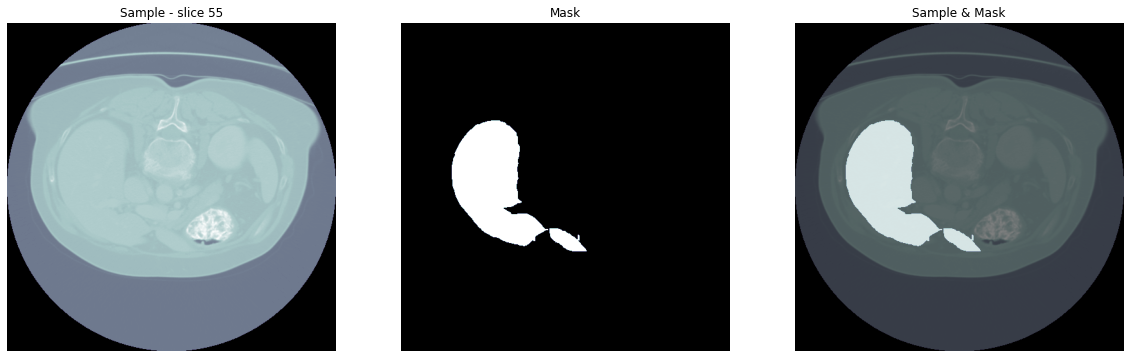

In [20]:
def vis(ct, mask=None, slice=0, cmap=plt.cm.bone):
    if mask is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    else:
        fig, ax1 = plt.subplots(figsize=(5, 5))

    ax1.imshow(ct [slice, ...], cmap=cmap)
    ax1.set_title(f'Sample - slice {slice}')
    ax1.axis('off')

    if mask is not None:
        ax2.imshow(mask[slice, ...], cmap=cmap)
        ax2.set_title('Mask')
        ax2.axis('off')

        ax3.imshow(ct[slice, ...], cmap=plt.cm.bone)
        ax3.imshow(mask[slice, ...], alpha=0.5, cmap=cmap)
        ax3.set_title('Sample & Mask')
        ax3.axis('off')

vis(ct, mask, 55)

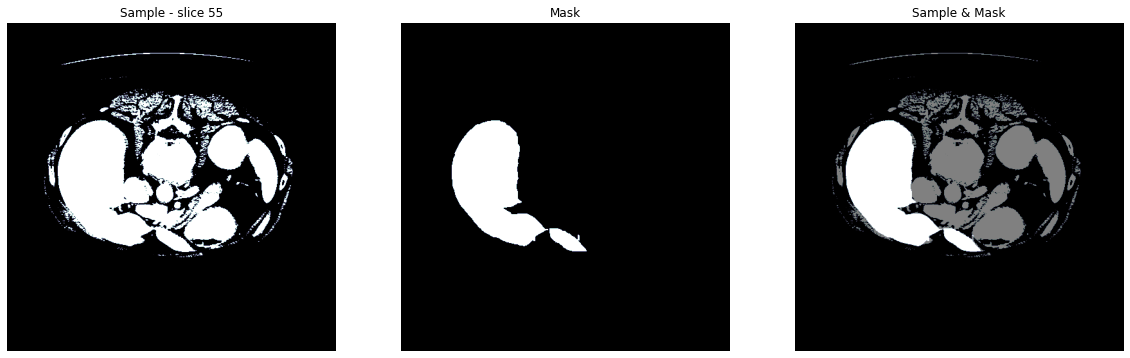

In [21]:
# https://en.wikipedia.org/wiki/Hounsfield_scale
dicom_windows = {
    'lung': (-700, -600),
    'kidney': (20, 45),
    'muscle': (35, 55),
    'fat': (-120, -90),
    'cancellous_bone': (300, 400),
    'cortical_bone': (500, 1900),
    'liver': (54, 66),
}

def apply_window(ct, window):
    ''' clip and scale '''
    clipped = torch.clip(ct, window[0], window[1])
    return (clipped - window[0]) / (window[1] - window[0])

ct_windowed = apply_window(ct, dicom_windows['liver'])
vis(ct_windowed, mask, slice=55)

torch.Size([75, 256, 256])


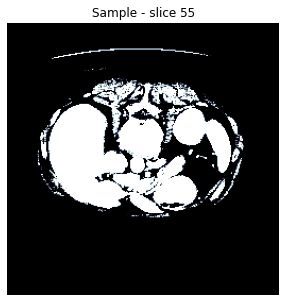

In [22]:
def resample(ct, avg_pooling=False):
    ''' resample (512x512 to 256x256), max pooling by default '''
    pool = F.avg_pool2d if avg_pooling else F.max_pool2d
    resampled = pool(ct, kernel_size=2, stride=2)
    return resampled

# max pooling resampling
ct_resampled = resample(ct_windowed)
print(ct_resampled.shape)
vis(ct_resampled, slice=55)

torch.Size([75, 256, 256])
torch.float32


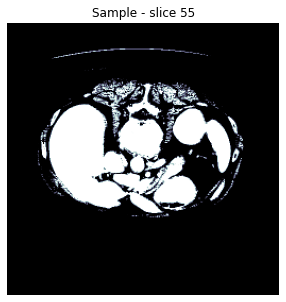

In [23]:
# avg pooling resampling
ct_resampled = resample(ct_windowed, avg_pooling=True)
print(ct_resampled.shape)
vis(ct_resampled, slice=55)
print(ct_resampled.dtype)

torch.uint8


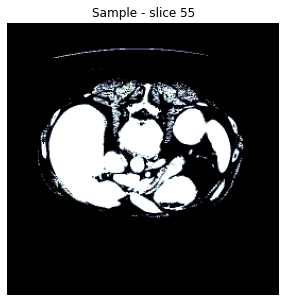

In [24]:
# convert to uint8
ct_win_int = (ct_resampled * 255).to(torch.uint8)
vis(ct_win_int, slice=55)
print(ct_win_int.dtype)